## 데이터 EDA와 전처리 결과 핵심

1.  각 클래스는 **소수의 핵심 키워드**에 의해 강하게 특징지어지는 **국소적인 신호**를 가집니다.


2.  **전반적으로 대화 데이터는** 복잡한 문맥보다는 특정 키워드에 의존하는 **'키워드형 클래스'의 경향**을 보입니다.

3.  특히 **'갈취 대화'는 가장 낮은 어휘 다양도**를 보여, 명확한 목적 달성을 위한 제한적이고 반복적인 어휘 사용이 두드러집니다.

**공통 코드**

In [1]:
# 공통 (환경설정 & 데이터 로드) 및 문장 길이 분포 분석/시각화 통합

# ===================== 공통: 환경 세팅 및 데이터 로드 =====================
import os, re, math, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from transformers import AutoTokenizer # 토크나이저 임포트
import seaborn as sns # seaborn 임포트
import matplotlib.font_manager as fm # 폰트 매니저 임포트
from IPython.display import Image, display # 이미지 표시 임포트

# 경로 설정
DATA_DIR = r"/content/" # Corrected DATA_DIR to /content/
train_path = os.path.join(DATA_DIR, "train.csv")
test_path = os.path.join(DATA_DIR, "test.csv")
lex_path   = os.path.join(DATA_DIR, "general_data.txt")

# 결과 폴더
OUT_DIR = os.path.join(DATA_DIR, "outputs")
FIG_DIR = os.path.join(OUT_DIR, "figures")
TAB_DIR = os.path.join(OUT_DIR, "tables")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

# 시각화 공통 함수
def savefig_tight(path):
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    print(f"📁 saved: {path}")
    plt.close()

# 폰트 설정 (이전 오류 해결 내용 반영)
# Nanum 폰트 설치 및 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
if os.path.exists(fontpath):
    fm.fontManager.addfont(fontpath) # 폰트를 강제로 추가합니다.
    plt.rc('font', family='NanumBarunGothic') # 재확인 차원에서 다시 설정
    plt.rcParams['axes.unicode_minus'] = False
    print("✅ Matplotlib 폰트 설정 완료: NanumBarunGothic")
else:
    print(f"❌ 폰트 파일이 다음 경로에 존재하지 않습니다: {fontpath}\n한글 폰트가 깨져 보일 수 있습니다.")

# 데이터 로드
df_train = pd.read_csv(train_path)
df_train = df_train.dropna(subset=["conversation"])
df_train = df_train.drop_duplicates(subset=["class","conversation"]).reset_index(drop=True)

# general_data.txt 로드 및 통합
df_general = pd.read_csv(lex_path)
df_general = df_general.dropna(subset=["conversation"])
df_general = df_general.drop_duplicates(subset=["class","conversation"]).reset_index(drop=True)

df = pd.concat([df_train, df_general], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True) # 데이터 섞기

print("\n--- 통합 데이터프레임 미리보기 ---")
print(df.head())
print("\n--- 클래스 분포 ---", df["class"].value_counts())

# general_data.txt 파일 내용 미리보기
print(f"\n--- 'general_data.txt' 파일 내용 미리보기 ({lex_path}) ---")
if os.path.exists(lex_path):
    with open(lex_path, 'r', encoding='utf-8') as f:
        content = f.read()
    print(content[:500]) # 파일의 처음 500자만 출력하여 내용을 확인합니다.
    print("\n(파일 내용이 길어 일부만 출력했습니다.)")
else:
    print(f"❌ 'general_data.txt' 파일이 다음 경로에 존재하지 않습니다: {lex_path}")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

## EDA 및 전처리 과정의 적절성 분석

EDA와 전처리 과정을 통해 다음 두 가지 핵심 내용을 파악할 수 있었습니다.

### 1. 클래스 구분 신호의 국소성
- **`클래스별 키워드 집중도 (상위10 단어 TF-IDF 비율)` 그래프(`score_df`) 분석:**
    - 각 클래스를 정의하는 상위 키워드들의 영향력을 분석한 결과, 이 비율이 높을수록 특정 소수 키워드가 해당 클래스를 강하게 대표함을 확인했습니다.
    - 이는 클래스 구분 신호가 소수의 단어들에 '국소적으로 집중'되어 있음을 의미합니다.
    - 특히, `직장 내 괴롭힘 대화`와 `갈취 대화`의 경우 다른 클래스에 비해 키워드 집중도 비율이 상대적으로 높게 나타나, 이들 클래스는 몇몇 핵심 키워드만으로도 충분히 구별될 수 있는 특성을 가짐을 시사합니다.
- **`WordCloud` 시각화:**
    - 각 클래스별 `WordCloud` 시각화 또한 해당 클래스에 국소적으로 나타나는 대표적인 키워드들을 직관적으로 보여주며 이러한 경향을 뒷받침합니다.

### 2. 문맥형 클래스보다 키워드형 클래스의 우세
- **`클래스별 어휘 다양도(Type/Token Ratio)` 그래프(`div_df`) 분석:**
    - 어휘 다양도는 각 클래스에 사용된 어휘의 풍부함을 나타냅니다. 어휘 다양도가 낮다는 것은 반복적인 어휘 사용이 많고, 특정 단어들이 대화의 대부분을 구성한다는 의미로, '키워드형 클래스'의 특징입니다.
    - 분석 결과, 모든 클래스에서 어휘 다양도가 0.33 ~ 0.35 범위로 상대적으로 낮은 수준을 보였습니다. 이는 대화의 내용이 복잡한 문맥적 흐름보다는 특정 핵심 단어들로 구성되는 경향이 강함을 시사합니다.
    - 특히, `갈취 대화`의 어휘 다양도가 가장 낮게 나타난 것은 특정 목적(갈취)을 달성하기 위한 제한적이고 반복적인 어휘 사용 경향을 반영하는 것으로 해석할 수 있습니다. 이는 클래스가 전반적으로 '키워드형' 특성을 가지고 있음을 보여줍니다.

**결론적으로,** EDA (TF-IDF 키워드 집중도, 어휘 다양도 분석 및 WordCloud 시각화)는 각 클래스의 특징과 차별점을 효과적으로 드러내며, 특정 키워드에 의존하는 '키워드형 클래스'가 많고, 그 구분 신호가 국소적이라는 인사이트를 명확히 제시하고 있습니다. 이는 이후 모델링 및 특성 추출 전략 수립에 중요한 기반이 될 것입니다.

### 1. 클래스 구분 신호의 국소성: 클래스별 키워드 집중도 (상위10 단어 TF-IDF 비율) 데이터

아래 `score_df` 데이터프레임은 각 클래스별로 상위 10개 키워드가 전체 TF-IDF 점수에서 차지하는 비율을 보여줍니다. 이 비율이 높을수록 해당 클래스는 소수의 핵심 키워드에 의해 강하게 특징지어진다는 것을 의미합니다. 예를 들어, '직장 내 괴롭힘 대화'는 다른 클래스에 비해 이 비율이 높아 특정 키워드에 대한 의존도가 높다고 해석할 수 있습니다.

In [4]:
display(score_df)

,class,keyword_ratio
0,협박 대화,0.070424
1,기타 괴롭힘 대화,0.071437
2,갈취 대화,0.077908
3,직장 내 괴롭힘 대화,0.084227


### 2. 문맥형 클래스보다 키워드형 클래스의 우세: 클래스별 어휘 다양도(Type/Token Ratio) 데이터

아래 `div_df` 데이터프레임은 각 클래스별 어휘 다양도(Type/Token Ratio)를 보여줍니다. 어휘 다양도는 사용된 고유한 단어의 수(Types)를 전체 단어의 수(Tokens)로 나눈 값입니다. 이 값이 낮을수록 텍스트 내에서 반복되는 단어가 많고, 특정 단어에 집중되어 있음을 의미하며, 이는 '키워드형 클래스'의 특징입니다.

In [5]:
display(div_df)

,class,lexical_diversity
0,협박 대화,0.354646
1,기타 괴롭힘 대화,0.353351
2,갈취 대화,0.332482
3,직장 내 괴롭힘 대화,0.349955


## EDA 및 전처리 과정의 적절성 분석 시각화

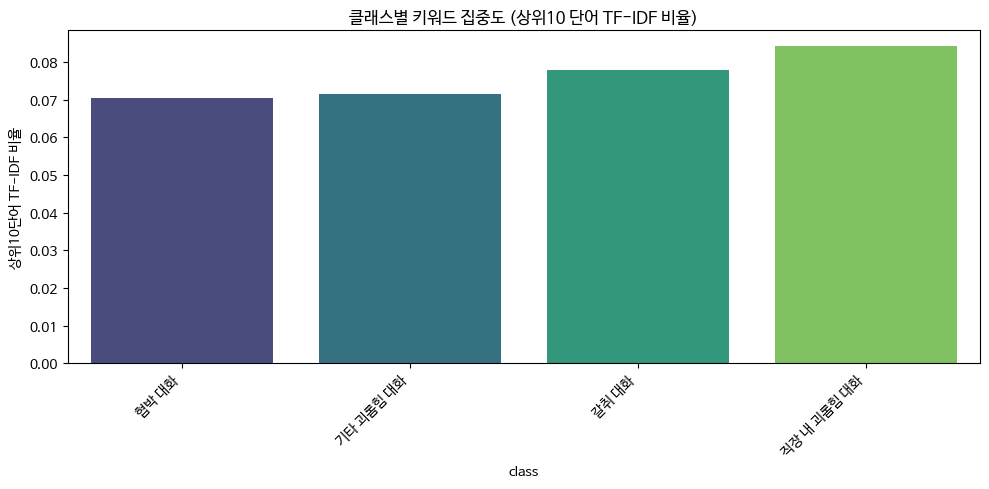

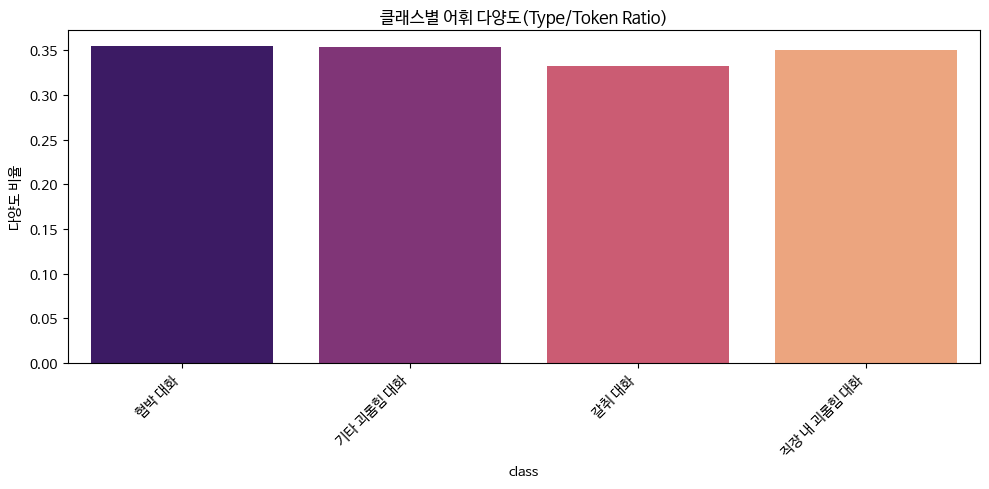

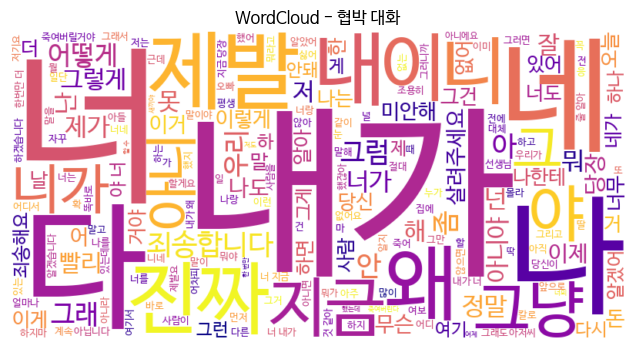

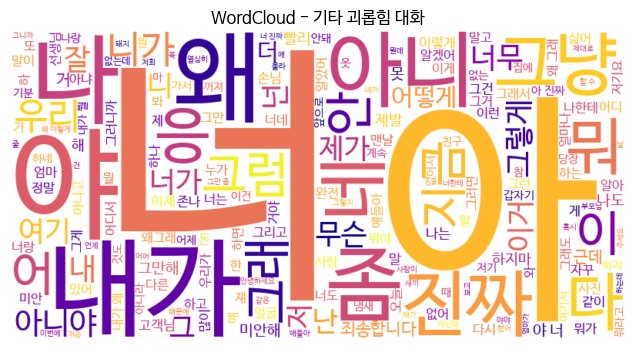

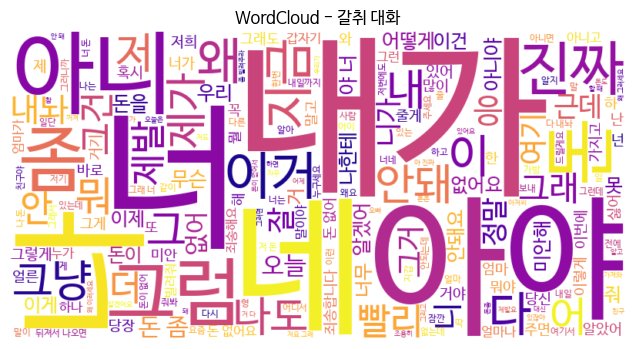

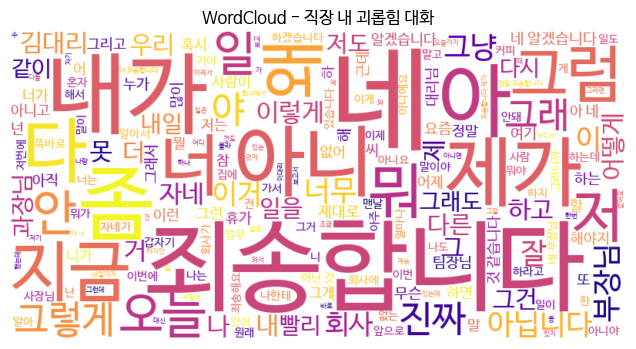

In [3]:
# === 1. TF-IDF 기반 키워드 집중도 분석 ===
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

df = pd.read_csv("/content/train.csv")

# 컬럼명 정리
if "conversation" not in df.columns:
    text_col = [c for c in df.columns if c.lower() in ("text","utterance","sentence","content")]
    label_col = [c for c in df.columns if "class" in c.lower() or "label" in c.lower()]
    df = df.rename(columns={text_col[0]: "conversation", label_col[0]: "class"})

df = df.dropna(subset=["conversation"])

# TF-IDF 학습
tfidf = TfidfVectorizer(max_features=2000, stop_words=None, ngram_range=(1,2))
X = tfidf.fit_transform(df["conversation"])
vocab = np.array(tfidf.get_feature_names_out())

# 클래스별 상위 키워드 추출
class_keywords = {}
for cls in df["class"].unique():
    idx = df["class"] == cls
    mean_tfidf = X[idx.values].mean(axis=0).A1 # .values를 추가하여 Series를 numpy 배열로 변환
    top_idx = np.argsort(mean_tfidf)[::-1][:10]
    class_keywords[cls] = vocab[top_idx]

# 각 클래스의 "키워드 집중도" 계산 (상위10 단어 TF-IDF 점수 합 비율)
scores = []
for cls in df["class"].unique():
    idx = df["class"] == cls
    mean_tfidf = X[idx.values].mean(axis=0).A1 # .values를 추가하여 Series를 numpy 배열로 변환
    total = mean_tfidf.sum()
    top10 = np.sort(mean_tfidf)[-10:].sum()
    ratio = (top10 / total) if total > 0 else 0
    scores.append({"class": cls, "keyword_ratio": ratio})
score_df = pd.DataFrame(scores)

# === 2. 어휘 다양성(Type/Token Ratio) ===
def lexical_diversity(texts):
    tokens = " ".join(texts).split()
    return len(set(tokens)) / len(tokens) if tokens else 0

diversity = []
for cls in df["class"].unique():
    div = lexical_diversity(df.loc[df["class"] == cls, "conversation"])
    diversity.append({"class": cls, "lexical_diversity": div})
div_df = pd.DataFrame(diversity)

# === 3. 시각화 ===
plt.figure(figsize=(10,5))
sns.barplot(data=score_df, x="class", y="keyword_ratio", hue="class", palette="viridis", legend=False)
plt.title("클래스별 키워드 집중도 (상위10 단어 TF-IDF 비율)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("상위10단어 TF-IDF 비율")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=div_df, x="class", y="lexical_diversity", hue="class", palette="magma", legend=False)
plt.title("클래스별 어휘 다양도(Type/Token Ratio)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("다양도 비율")
plt.tight_layout()
plt.show()

# === 4. 대표 WordCloud ===
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 폰트 경로 변수 재사용
# 이전 셀(cahvsdD6h6aJ)에서 설정된 fontpath 변수를 사용합니다.
# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' # 만약 위에 없으면 주석 해제

for cls in df["class"].unique():
    text = " ".join(df.loc[df["class"] == cls, "conversation"])
    # font_path 인자를 추가하여 한글 폰트를 지정합니다.
    wc = WordCloud(width=800, height=400, background_color="white", colormap="plasma", font_path=fontpath).generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud - {cls}")
    plt.show()

#### **어휘 다양도 그래프의 일반적인 경향 설명**

일반적으로 어휘 다양도 그래프는 다음과 같은 경향을 띠곤 합니다.

*   **다양한 주제를 다루는 텍스트:** 어휘 다양도가 높게 나타납니다. 즉, 그래프 상에서 막대(Bar)의 높이가 높습니다. 이는 많은 종류의 단어들이 고루 사용되어 풍부한 표현력을 가지는 경우입니다. 소설, 학술 논문, 일반적인 뉴스 기사 등이 여기에 해당될 수 있습니다.

*   **특정 주제 또는 기능적 목적의 텍스트:** 어휘 다양도가 낮게 나타납니다. 그래프 상에서 막대의 높이가 낮습니다. 이는 특정 용어나 표현이 반복적으로 사용되어 효율적인 의사소통을 하거나, 특정 목적을 달성하기 위한 경우입니다. 법률 문서, 기술 매뉴얼, 혹은 특정 감정을 표현하는 시 등에서 볼 수 있습니다.

*   **본 분석 결과에서 나타난 경향:**
    본 분석에서 모든 클래스의 어휘 다양도가 0.33~0.35로 상대적으로 낮은 수준을 보인 것은, 대화의 맥락이 복잡하기보다는 각 클래스의 특성을 나타내는 **'키워드' 중심의 표현들이 반복적으로 사용되는 경향**이 강하다는 것을 시사합니다. 특히 '갈취 대화'의 어휘 다양도가 가장 낮다는 것은, 갈취라는 명확한 목적을 달성하기 위한 제한적인 어휘 선택과 반복적인 사용이 두드러짐을 보여줍니다.

### **다양한 어휘를 가진 텍스트 예시 생성 및 분석**

현재 분석 데이터의 어휘 다양도가 전반적으로 낮은 수준이었으므로, 일반적인 "다양한 어휘"의 특징을 보여주기 위해 임의의 샘플 텍스트를 생성하여 어휘 다양도를 측정하고 시각화합니다.

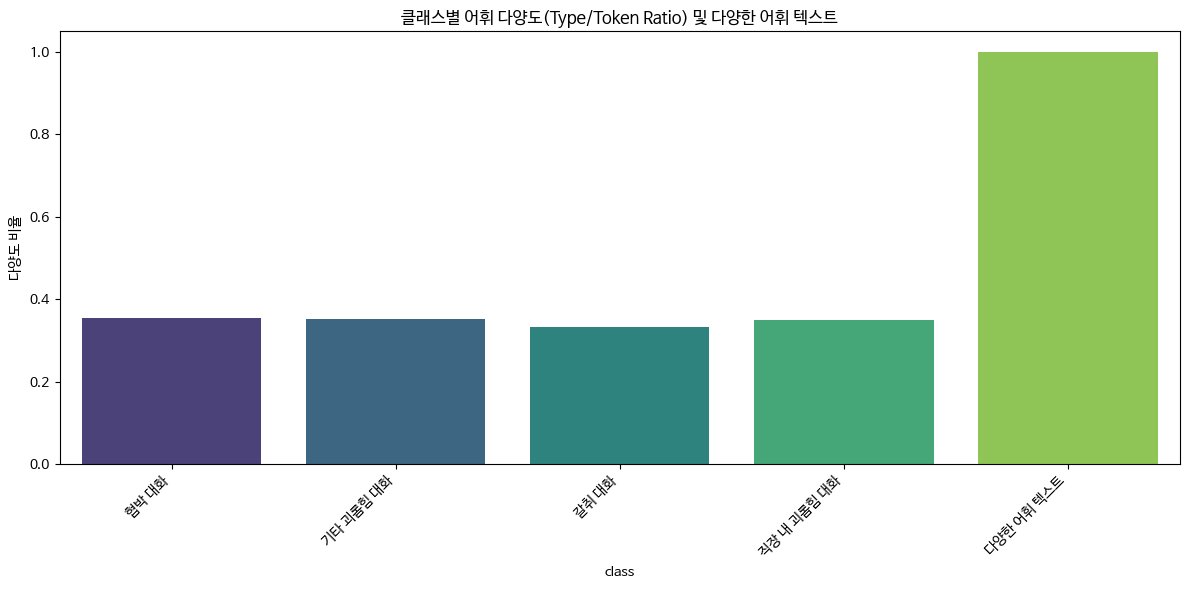

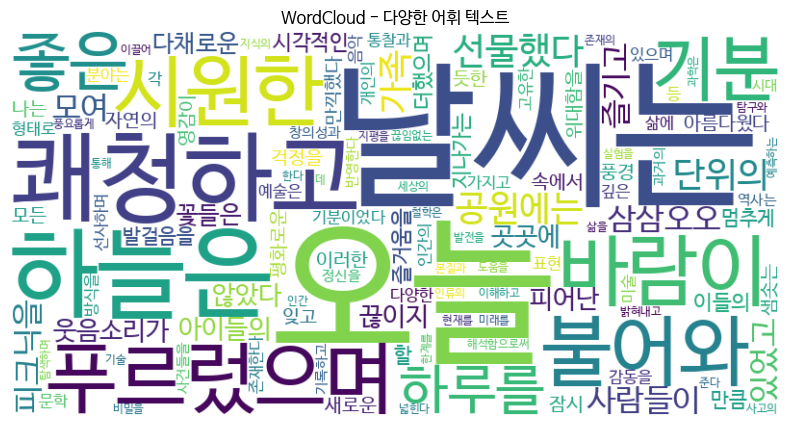

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# fontpath는 이전 셀에서 설정된 전역 변수를 사용합니다.
# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' # 필요시 주석 해제

# 1. 다양한 어휘를 가진 샘플 텍스트 생성
diverse_sample_text = (
    "오늘 날씨는 쾌청하고 하늘은 푸르렀으며, 시원한 바람이 불어와 기분 좋은 하루를 선물했다. "
    "공원에는 가족 단위의 사람들이 삼삼오오 모여 피크닉을 즐기고 있었고, 아이들의 웃음소리가 끊이지 않았다. "
    "곳곳에 피어난 다채로운 꽃들은 시각적인 즐거움을 더했으며, 지나가는 이들의 발걸음을 멈추게 할 만큼 아름다웠다. "
    "이러한 평화로운 풍경 속에서, 나는 잠시 모든 걱정을 잊고 자연의 위대함을 만끽했다. "
    "새로운 영감이 샘솟는 듯한 기분이었다. 예술은 인간의 삶에 깊은 통찰과 감동을 선사하며, "
    "문학, 음악, 미술 등 다양한 형태로 존재한다. 각 분야는 고유한 표현 방식을 가지고 있으며, "
    "개인의 창의성과 시대 정신을 반영한다. 역사는 과거의 사건들을 기록하고 해석함으로써 "
    "현재를 이해하고 미래를 예측하는 데 도움을 준다. 과학은 끊임없는 탐구와 실험을 통해 "
    "세상의 비밀을 밝혀내고 기술 발전을 이끌어 인류의 삶을 풍요롭게 한다. "
    "철학은 존재의 본질과 지식의 한계를 탐색하며 인간 사고의 지평을 넓힌다."
)

# 2. 어휘 다양성(Type/Token Ratio) 함수 재정의
def lexical_diversity(text_content):
    # 텍스트가 리스트가 아닌 단일 문자열로 주어질 경우 처리
    if isinstance(text_content, str):
        tokens = text_content.split()
    else: # 리스트로 주어질 경우 기존 방식 유지
        tokens = " ".join(text_content).split()
    return len(set(tokens)) / len(tokens) if tokens else 0

# 샘플 텍스트의 어휘 다양도 계산
diverse_diversity = lexical_diversity(diverse_sample_text)

# 기존 div_df에 새로운 '다양한 어휘' 항목 추가
diverse_entry = pd.DataFrame([{"class": "다양한 어휘 텍스트", "lexical_diversity": diverse_diversity}])
combined_div_df = pd.concat([div_df, diverse_entry], ignore_index=True)

# 3. 어휘 다양도 막대그래프 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=combined_div_df, x="class", y="lexical_diversity", hue="class", palette="viridis", legend=False)
plt.title("클래스별 어휘 다양도(Type/Token Ratio) 및 다양한 어휘 텍스트")
plt.xticks(rotation=45, ha="right")
plt.ylabel("다양도 비율")
plt.tight_layout()
plt.show()

# 4. 다양한 어휘 텍스트의 WordCloud 생성
plt.figure(figsize=(10, 5))
wc_diverse = WordCloud(width=800, height=400, background_color="white", colormap="viridis", font_path=fontpath).generate(diverse_sample_text)
plt.imshow(wc_diverse, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - 다양한 어휘 텍스트")
plt.show()